In [15]:
library(keras)
library(tidyverse)
library(jsonlite)
library(abind)
library(gridExtra)
options(warn=0)

In [16]:
ships_json <- fromJSON("ships_images/shipsnet.json")[1:2]

ships_data <- ships_json$data %>%
  apply(., 1, function(x) {
    r <- matrix(x[1:6400], 80, 80, byrow = TRUE) / 255
    g <- matrix(x[6401:12800], 80, 80, byrow = TRUE) / 255
    b <- matrix(x[12801:19200], 80, 80, byrow = TRUE) / 255
    list(array(c(r,g,b), dim = c(80, 80, 3)))
  }) %>%
  do.call(c, .) %>%
  abind(., along = 4) %>%
  aperm(c(4, 1, 2, 3))

ships_labels <- ships_json$labels %>%
  to_categorical(2)

rm(ships_json)
dim(ships_data)

[1] 3600   80   80    3

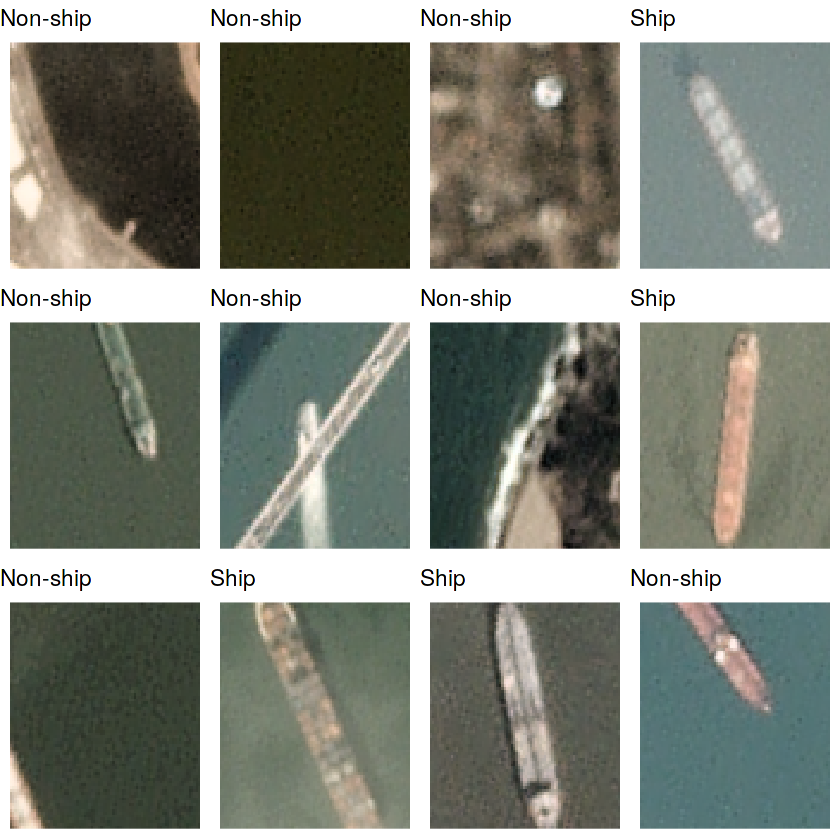

In [17]:
xy_axis <- data.frame(x = expand.grid(1:80, 80:1)[, 1],
                      y = expand.grid(1:80, 80:1)[, 2])
set.seed(1111)
sample_plots <- sample(1:dim(ships_data)[1], 12) %>%
  map(~ {
    plot_data <- cbind(xy_axis, r = as.vector(t(ships_data[.x, , , 1])),
                       g = as.vector(t(ships_data[.x, , , 2])),
                       b = as.vector(t(ships_data[.x, , , 3])))
    ggplot(plot_data, aes(x, y, fill = rgb(r, g, b))) + guides(fill = FALSE) +
      scale_fill_identity() + theme_void() + geom_raster(hjust = 0, vjust = 0) +
      ggtitle(ifelse(ships_labels[.x, 2], "Ship", "Non-ship"))
  })

do.call("grid.arrange", c(sample_plots, ncol = 4, nrow = 3))

In [7]:
set.seed(1234)
indexes <- sample(1:nrow(ships_labels), 0.7 * nrow(ships_labels))
train <- list(data = ships_data[indexes, , , ], labels = ships_labels[indexes, ])
test <- list(data = ships_data[-indexes, , , ], labels = ships_labels[-indexes, ])

In [9]:
model <- keras_model_sequential()

In [10]:
model %>%
  # 32 filters, each size 3x3 pixels
  # ReLU activation after convolution
  layer_conv_2d(
    input_shape = c(80, 80, 3),
    filter = 32, kernel_size = c(3, 3), strides = c(1, 1),
    activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2)) %>%
  layer_conv_2d(filter = 64, kernel_size = c(3, 3), strides = c(1, 1),
                activation = "relu") %>%
  layer_max_pooling_2d(pool_size = c(2, 2), strides = c(2, 2)) %>%
  layer_flatten() %>%
  layer_dense(2, activation = "softmax")

summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 78, 78, 32)              896         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 39, 39, 32)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 37, 37, 64)              18496       
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 18, 18, 64)              0           
________________________________________________________________________________
flatten_1 (Flatten)                 (None, 20736)                   0           
________________________________________________________________________________
dense_1 (Dense)             

In [11]:
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_sgd(lr = 0.0001, decay = 1e-6),
  metrics = "accuracy")

In [12]:
tensorboard("logs/ships")

ships_fit <- model %>% fit(x = train[[1]], y = train[[2]], epochs = 20, batch_size = 32,
                           validation_split = 0.2,
                           callbacks = callback_tensorboard("logs/ships"))

Started TensorBoard at http://127.0.0.1:4382 


0.7773730,0.2226270,0,1
0.6989846,0.3010154,0,1
0.6016771,0.3983229,0,1
0.6909457,0.3090543,0,1
0.7181076,0.2818924,0,1
0.7786814,0.2213186,0,1


$loss
[1] 0.5397645

$acc
[1] 0.7509259

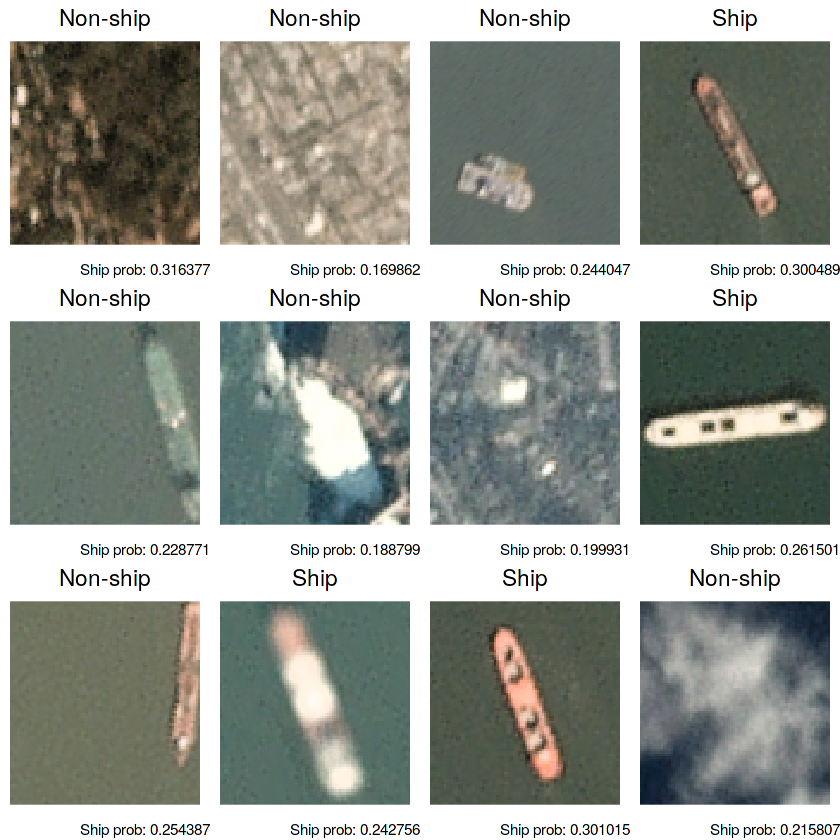

In [14]:
predicted_probs <- model %>%
  predict_proba(test[[1]]) %>%
  cbind(test[[2]])

head(predicted_probs)

model %>% evaluate(test[[1]], test[[2]])

set.seed(1111)
sample_plots <- sample(1:dim(test[[1]])[1], 12) %>%
  map(~ {
    plot_data <- cbind(xy_axis, r = as.vector(t(test[[1]][.x, , , 1])),
                       g = as.vector(t(test[[1]][.x, , , 2])),
                       b = as.vector(t(test[[1]][.x, , , 3])))
    ggplot(plot_data, aes(x, y, fill = rgb(r, g, b))) + guides(fill = FALSE) +
      scale_fill_identity() + theme_void() + geom_raster(hjust = 0, vjust = 0) +
      ggtitle(ifelse(test[[2]][.x, 2], "Ship", "Non-ship")) +
      labs(caption = paste("Ship prob:", round(predicted_probs[.x, 2], 6))) +
      theme(plot.title = element_text(hjust = 0.5))
  })

do.call("grid.arrange", c(sample_plots, ncol = 4, nrow = 3))